In [1]:
'''
Update from v02:
-use variable_scopes to define graph more specifically
-optimize the text preprocessing step
-implement rnn
'''

## import packages
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import pandas as pd
import tensorflow as tf
import collections
import random
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import nltk
import itertools
import matplotlib.pyplot as plt
import re
import pickle

/home/bsong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
## import data 
start_time = time.time()

train_raw = pd.read_csv('/home/bsong/Python_Stuff/Data/Kaggle_Mercari/train.tsv',delimiter= '\t')
#train_raw = train_raw.iloc[0:10000,] # just a bit
# standardize price here because may as well
normalized_price = np.log1p(train_raw['price'].values)
mean_price_norm = np.mean(normalized_price)
std_price_norm = np.std(normalized_price) 
train_raw['price'] = (normalized_price - mean_price_norm)/std_price_norm 

end_time = time.time()
print('import data took ' + str(end_time - start_time) + " seconds.")

import data took 8.957505464553833 seconds.


In [3]:
## define functions to use

######## Basic text manipulation functions (some specific to Mercari Kaggle Competition) 

def split_cat(text): # this one is to reduce the categoriy_name into three subcategories
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

def handle_missing_inplace(dataset):  # this one is to put placeholders in place of missing values (NaN)
    dataset['cat1'].fillna(value='No Label', inplace=True)
    dataset['cat2'].fillna(value='No Label', inplace=True)
    dataset['cat3'].fillna(value='No Label', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='No description yet', inplace=True)
     
def build_dictionary(words, n_words): # dictionary that maps words to indices. this function should be modular.
    #input is [['a','b','c'],['a','b','c']]
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]] # word indexed as "unknown" if not one of the top #n_words (popular/common) words (-1 is filler #)
    count.extend(Counter(words).most_common(n_words - 1)) # most_common returns the top (n_words-1) ['word',count]
    dictionary = dict()
    for word, _ in count: # the 'word, _' is writted because count is a list of list(2), so defining 'word' as the first term per
        dictionary[word] = len(dictionary) # {'word': some number incrementing by one. fyi, no repeats because from most_common)}
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys())) # {ind. : 'word'} I guess for looking up if needed?
    return dictionary, reversed_dictionary

def clean_and_tokenize(dataset_col): # input is a column of strings
    pattern = '[A-Za-z]+' # does this only keep words
    pattern2 = '[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n]' # to rid of special characters
    list_of_lists = list()
    tokenizer = RegexpTokenizer(pattern)
    stop_words = set(stopwords.words('english'))
    for word in dataset_col:
        list_of_words = list()
        word = re.sub(pattern2, r'', word)
        tokenized = tokenizer.tokenize(word)
        tokenized_filtered = filter(lambda token: token not in stop_words, tokenized)
        for i in tokenized_filtered:
            if (len(i) > 2 ): #ignore words of length 2 or less
                list_of_words.append(i.lower()) # append all words to one list
        list_of_lists.append(list_of_words)
    list_as_series = pd.Series(list_of_lists)
    return list_as_series

def just_punc_and_lower(dataset_col):
    pattern = '[A-Za-z]+' # does this only keep words
    pattern2 = '[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n]' # to rid of special characters
    tokenizer = RegexpTokenizer(pattern)
    list_of_lists = list()
    for word in dataset_col:
        word = re.sub(pattern2,r'',word)
        list_of_words = word.lower().split(' ')
        list_of_lists.append(list_of_words)
    list_as_series = pd.Series(list_of_lists)
    return list_as_series

def convert_word_to_ind(dataset_col,dictionary): # input the pandas column of texts and dictionary. This should be modular
    # each input should be a string of cleaned words tokenized into a list (ex. ['this', 'is', 'an', 'item'])
    # dictionary should be the dictionary obtained from build_dictionary
    list_of_lists = []
    unk_count = 0 # total 'unknown' words counted
    for word_or_words in dataset_col: # words is the list of all words
        list_of_inds = []
        for word in word_or_words:
            if word in dictionary:
                index = np.int(dictionary[word]) # dictionary contains top words, so if in, it gets an index
            else:
                index = 0  #  or dictionary['UNK']? can figure out later
                unk_count += 1
            list_of_inds.append(index)
        list_of_lists.append(list_of_inds)

    # make list_of_lists into something that can be put into pd.DataFrame
    #list_as_series = pd.Series(list_of_lists)
    list_as_series = np.array(list_of_lists)
    return list_as_series, unk_count

def pad_word_indices(col_of_indices, pad_length): # col_of_indices can be a pd series. 
    temp_series = [] # append vectors into here
    for list_inds in col_of_indices:
        len_list = len(list_inds)
        if len_list >= pad_length:
            temp_series.append(np.array(list_inds[(len_list-pad_length):]))
        else:
            padded_vec = [0]*(pad_length-len_list)
            padded_vec.extend(list_inds)
            temp_series.append(np.array(padded_vec))
    return temp_series

def convert_word_to_padded(dataset_col,dictionary,pad_length): # input the pandas column of texts and dictionary. This should be modular
    # each input should be a string of cleaned words tokenized into a list (ex. ['this', 'is', 'an', 'item'])
    # dictionary should be the dictionary obtained from build_dictionary
    # use this function when you know how long you want your pad_length
    #   - otherwise, use convert_word_to_ind, and pad_word_indices
    #   - eventually, will look into cleaning these three functions up.
    list_of_lists = []
    unk_count = 0 # total 'unknown' words counted
    for word_or_words in dataset_col: # words is the list of all words
        list_of_inds = []
        count_inds = 0
        for word in word_or_words:
            if word in dictionary:
                index = np.int(dictionary[word]) # dictionary contains top words, so if in, it gets an index
            else:
                index = 0  #  or dictionary['UNK']? can figure out later
                unk_count += 1
            count_inds +=1
            list_of_inds.append(index) 
        if count_inds >= pad_length:
            asdf = list_of_inds[(count_inds-pad_length):]
        else: 
            asdf = [0]*(pad_length-count_inds)
            asdf.extend(list_of_inds)
        temp = np.array(asdf)
        list_of_lists.append(temp)
    list_as_series = np.array(list_of_lists)
    return list_as_series, unk_count

######## Word Embedding (this is after strings are transformed into vectors of indices)

# generate batch data (for feeding into word embedding)
# used http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ for reference
def generate_batch(data, batch_size, num_skips): 
    # data should be [[3,7,9],[7,4,5,9],...] kinda format
    # num_skips configures number of context words to draw. skip_window defines size of window to draw context words from
    assert batch_size % num_skips == 0 # if batch_size was 10, and num_skips was 3, then [cat,cat,cat,sat,sat,sat,...] wont equal
    batch = np.ndarray(shape=(batch_size), dtype=np.int32) # initialize batch variable (input word go in here)
    context = np.ndarray(shape=(batch_size, 1), dtype=np.int32) # initialize context variable
    counter = 0
    rand_dat_ind = random.sample(range(0,len(data)-1),int(batch_size/num_skips))
    for i in data[rand_dat_ind]:
        while len(i) <= num_skips:
            rnd_again = random.randint(0,len(data)-1)
            i = data[rnd_again]
        target = random.randint(0,len(i)-1) 
        targets_to_avoid = [target] # avoid this index when selecting rando words
        for j in range(num_skips):
            while target in targets_to_avoid: # this is to choose an index that isnt the index of the batch word
                target = random.randint(0, len(i)-1) # target is a context word
            targets_to_avoid.append(target) # so next time, this loop won't select this context word again 
            batch[counter] = i[targets_to_avoid[0]]  # this is the input word (same word repeated i*num_skips+j times)
            context[counter, 0] = i[targets_to_avoid[j+1]]  # these are the context words to the batch word
            counter += 1
    return batch, context # batch is input, context is target variable(s)

def generate_batch_general(x, y, batch_size):
    # this is to generate batches for word2vec comparing against numeric values 
    # in this case, 'brand_name' and cat1/2/3 are compared against 'price'
    rand_dat_ind = random.sample(range(0,len(data)-1),int(batch_size))
    return x[rand_dat_ind], y[rand_dat_ind]
    

In [4]:
## clean "category_name" and make numeric indicies for one-worded features (brand_name, cat1/2/3)

start_time = time.time()

train_raw['cat1'],train_raw['cat2'],train_raw['cat3'] = \
zip(*train_raw['category_name'].apply(lambda x: split_cat(x))) # split the categories into three new columns
train_raw.drop('category_name',axis = 1, inplace = True) # remove the column that isn't needed anymore

handle_missing_inplace(train_raw) # replaces NaN with a string placeholder 'missing'

end_time = time.time()
print('cleaning "category_name" and making one-worded features to indices took ' + str(end_time - start_time) + " seconds.")

cleaning "category_name" and making one-worded features to indices took 8.736202001571655 seconds.


In [5]:
## convert name and item_desc to indices, then configure a bit more

start_time = time.time()

all_name_desc = np.hstack((train_raw['name'],train_raw['item_description'])) # get all dem words
all_name_desc = clean_and_tokenize(all_name_desc)
all_name_desc = [item for sublist in all_name_desc for item in sublist]
train_raw['name'] = clean_and_tokenize(train_raw['name'])
train_raw['item_description'] = clean_and_tokenize(train_raw['item_description'])

#make new columns of just the indices of the words for name and item_description
vocabulary_size = 9803 # keeping 100000 words in the dictionary. can adjust later. will use variable elsewhere
word2vec_dict, reverse_dict = build_dictionary(all_name_desc,vocabulary_size) 
train_raw['name_inds'], count_unk_name = convert_word_to_ind(train_raw['name'],word2vec_dict) 
train_raw['item_desc_inds'], count_unk_item_desc = convert_word_to_ind(train_raw['item_description'], word2vec_dict)  

print("total words (with repeats): " + str(len(all_name_desc)))
print("total unassigned words in name and item_description: "+ str(count_unk_name) +  ' ' + str(count_unk_item_desc))

end_time = time.time()
print('converting name and item_desc to indices and config took ' + str(end_time - start_time) + " seconds.")

0.06178545951843262
total words (with repeats): 30278275
total unassigned words in name and item_description: 381710 1133021
converting name and item_desc to indices and config took 184.25964546203613 seconds.


max tokens in 'name': 9


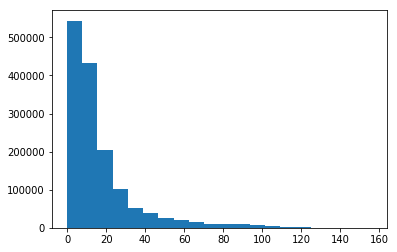

max tokens in 'item_desc': 156
57


In [6]:
## deciding pad length for name and item_desc  

a = [len(i) for i in train_raw.name_inds]
print("max tokens in 'name': " + str(max(a)))

b = [len(i) for i in train_raw.item_desc_inds]
plt.hist(b,20)
plt.show()
print("max tokens in 'item_desc': " + str(max(b)))

sort_b = sorted(b) #sorted length in increasing order
perc_data = .95
len_item_desc_potential = sort_b[round(perc_data*len(sort_b))]
print(len_item_desc_potential) # this represents (perc_data)% of item descriptions are under (len_item_desc_potential) words



In [7]:
## deciding dictionary size for brand and cat1/2/3

brand_unique_set = set(train_raw.brand_name.values)
print('Number of unique brands: ' + str(len(brand_unique_set)))

cat1_set = set(train_raw.cat1.values)
print('Number of unique categories in cat1: ' + str(len(cat1_set)))

cat2_set = set(train_raw.cat2.values)
print('Number of unique categories in cat1: ' + str(len(cat2_set)))

cat3_set = set(train_raw.cat3.values)
print('Number of unique categories in cat1: ' + str(len(cat3_set)))

Number of unique brands: 4810
Number of unique categories in cat1: 11
Number of unique categories in cat1: 114
Number of unique categories in cat1: 871


In [8]:
## make dictionaries for brand_name and cat1/2/3

start_time = time.time()
# define dictionary lengths here
dict_brand_len = 4811 # total words + 1 for "UNK" is minimal size
dict_cat1_len = 12 
dict_cat2_len= 115 
dict_cat3_len = 872 

brand_name_dict, brand_name_dict_rev = build_dictionary(train_raw['brand_name'], dict_brand_len)
train_raw['brand_name_inds'], count_unk_brand = convert_word_to_ind(train_raw['brand_name'].values.reshape((-1,1)), brand_name_dict)
cat1_dict ,cat1_rev_dict= build_dictionary(train_raw['cat1'],dict_cat1_len)
train_raw['cat1_inds'], count_unk_cat1 = convert_word_to_ind(train_raw['cat1'].values.reshape((-1,1)), cat1_dict)
cat2_dict ,cat2_rev_dict= build_dictionary(train_raw['cat2'],dict_cat2_len)
train_raw['cat2_inds'], count_unk_cat2 = convert_word_to_ind(train_raw['cat2'].values.reshape((-1,1)), cat2_dict)
cat3_dict ,cat3_rev_dict= build_dictionary(train_raw['cat3'],dict_cat3_len)
train_raw['cat3_inds'], count_unk_cat3 = convert_word_to_ind(train_raw['cat3'].values.reshape((-1,1)), cat3_dict)

print(str(count_unk_brand) + ' ' + str(count_unk_cat1) + ' '+ str(count_unk_cat2) + " " + str(count_unk_cat3))

end_time = time.time()
print('making dictionaries for brand and categories took ' + str(end_time - start_time) + " seconds.")

0 0 0 0
making dictionaries for brand and categories took 29.997793197631836 seconds.


In [9]:
## padding name and item_desc here. these will be trained in the final model (as opposed to pretrained)

start_time = time.time()

name_pad_size = 9 # max length of name
itemdesc_pad_size = 25 # 95th percentile of length of item descriptions

name_padded , _ = convert_word_to_padded(train_raw.name,word2vec_dict,name_pad_size) # without _, will get tuple lol.
itemdesc_padded , _ = convert_word_to_padded(train_raw.item_description,word2vec_dict,itemdesc_pad_size) 

end_time = time.time()
print('converting name and item_desc to padded indices took ' + str(end_time - start_time) + " seconds.")

converting name and item_desc to padded indices took 35.706812381744385 seconds.


In [10]:
def obtain_reasonable_vocab_size(list_words, perc_words = .95):
    counter_ = Counter(list_words)
    counts = [i for _,i in counter_.most_common()]
    tot_words = len(list_words)
    print('total words (with repeats): ' + str(tot_words))
    tot_count = 0
    runs = 0
    while tot_count < round(perc_words*tot_words):
        tot_count += counts[runs]
        runs += 1
    print('reasonable vocab size: ' + str(runs))

def obtain_reasonable_pad_length(list_words, perc_words = 0.95):
    len_list = [len(i) for i in list_words]
    sort_list = sorted(len_list)
    ind_good = sort_list[round(perc_words*len(sort_list))]
    print('reasonable pad length: ' + str(ind_good))

In [11]:
'''## tokenized name and item_description without removing works. only lowercase

train_raw['name_token'] = just_punc_and_lower(train_raw.name)
train_raw['itemdesc_token'] = just_punc_and_lower(train_raw.item_description)

## used below two blocks or so
all_name = [item for sublist in train_raw.name_token for item in sublist]
all_item_desc = [item for sublist in train_raw.itemdesc_token for item in sublist]'''

"## tokenized name and item_description without removing works. only lowercase\n\ntrain_raw['name_token'] = just_punc_and_lower(train_raw.name)\ntrain_raw['itemdesc_token'] = just_punc_and_lower(train_raw.item_description)\n\n## used below two blocks or so\nall_name = [item for sublist in train_raw.name_token for item in sublist]\nall_item_desc = [item for sublist in train_raw.itemdesc_token for item in sublist]"

In [12]:
'''## Get an idea of what length of padding should be done

len_list = [len(i) for i in train_raw.name_token.values]

plt.hist(len_list, bins = 10)
plt.show()
obtain_reasonable_pad_length(train_raw.name_token.values)

len_list = [len(i) for i in train_raw.itemdesc_token.values]
plt.hist(len_list, bins = 20)
plt.show()
obtain_reasonable_pad_length(train_raw.itemdesc_token.values)

## Also obtain a decent dictionary size
obtain_reasonable_vocab_size(all_name)
obtain_reasonable_vocab_size(all_item_desc)'''

'## Get an idea of what length of padding should be done\n\nlen_list = [len(i) for i in train_raw.name_token.values]\n\nplt.hist(len_list, bins = 10)\nplt.show()\nobtain_reasonable_pad_length(train_raw.name_token.values)\n\nlen_list = [len(i) for i in train_raw.itemdesc_token.values]\nplt.hist(len_list, bins = 20)\nplt.show()\nobtain_reasonable_pad_length(train_raw.itemdesc_token.values)\n\n## Also obtain a decent dictionary size\nobtain_reasonable_vocab_size(all_name)\nobtain_reasonable_vocab_size(all_item_desc)'

In [13]:
'''
## Recurrent NN setup for name and item_description

dict_name_len = 12000
dict_itemdesc_len = 8737
name_pad_len = 7
itemdesc_pad_len = 91

# build dictionary for indices and use it to convert word to indices
# same time, the indices will be padded to maintain np.array dtype

name_dict, name_dict_rev = build_dictionary(all_name, dict_name_len)
name_padded, _ = convert_word_to_padded(train_raw.name_token, name_dict, name_pad_len)

itemdesc_dict, itemdesc_dict_rev = build_dictionary(all_item_desc, dict_itemdesc_len)
itemdesc_padded, _ = convert_word_to_padded(train_raw.itemdesc_token, itemdesc_dict, itemdesc_pad_len)
'''

'\n## Recurrent NN setup for name and item_description\n\ndict_name_len = 12000\ndict_itemdesc_len = 8737\nname_pad_len = 7\nitemdesc_pad_len = 91\n\n# build dictionary for indices and use it to convert word to indices\n# same time, the indices will be padded to maintain np.array dtype\n\nname_dict, name_dict_rev = build_dictionary(all_name, dict_name_len)\nname_padded, _ = convert_word_to_padded(train_raw.name_token, name_dict, name_pad_len)\n\nitemdesc_dict, itemdesc_dict_rev = build_dictionary(all_item_desc, dict_itemdesc_len)\nitemdesc_padded, _ = convert_word_to_padded(train_raw.itemdesc_token, itemdesc_dict, itemdesc_pad_len)\n'

In [61]:
#tf.reset_default_graph()

In [62]:
## regular neural network function define here
# This is to use for the simpler columns (brand_name, item_condition, cat1/2/3)
# note to self: maybe separating dropout is better for manipulation purposes (and pooling and dropout lol.)

# RegNN used for converting embedded features into whatever out_nodes. 
# I feel dense_NN achieves the exact same thing, but one layer, but this happened because I was iteratively progressing through this 
# project and didn't want to erase too many things. 1/11/18

def RegNN(x, dropout_keep_prob, vocab_size, embed_size, batch_len, out_len):
    #print('shape of input:' + str(x.shape))
    # x should be of size [batch_len,embed_size] 
    # set up some weights/bias stuff
    W1 = tf.Variable(tf.truncated_normal([vocab_size,embed_size], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[vocab_size,1])) # maybe batch_len   
    #print('shape of W1:' + str(W1.shape))
    #print('shape of b1:' + str(b1.shape))
    
    # xW + b 
    NN_layer = tf.matmul(W1,tf.transpose(x)) + b1 # this outputs shape (vocab_size,batch_len)
    #print('NN_layer shape: ' + str(NN_layer.shape)) 
    # ReLU layer
    
    h = tf.nn.relu(NN_layer)
    
    # Drop Layer
    h_drop = tf.nn.dropout(h, dropout_keep_prob) # still (vocab_size,batch_len)
    
    #W2 = tf.Variable(tf.truncated_normal([vocab_size,out_len]))
    #b2 = tf.constant(0.1, shape=[batch_len,1])
    
    #NN_layer2 = tf.matmul(tf.transpose(h_drop),W2) + b2 # this outputs shape (batch_len,out_len)
    #print('NN_layer2 shape: ' + str(NN_layer2.shape))
    #h2 = tf.nn.relu(NN_layer2)
    #h2_drop = tf.nn.dropout(h2, dropout_keep_prob) # should be of length (batch_len, out_len)
    
    return h_drop #h2_drop


def embed(inputs, size, dim,name):
    # inputs is a list of indices
    # size is the number of unique indices (look for max index to achieve this if ordered)
    # dim is the number of embedded numbers 
    std = np.sqrt(2 / dim)
    emb = tf.Variable(tf.random_uniform([size, dim], -std, std), name = name)
    return emb

# test block for CNN 
# based on http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
# note to self: maybe separating dropout is better for manipulation purposes (and pooling and dropout lol.)

def CNN(x,W_shape,b_shape,pad_length, name_w, name_b):
    # x is the expanded lookup tables that will be trained
    W1 = tf.Variable(tf.truncated_normal(W_shape, stddev=0.1), name= name_w) #"W1"
    b1 = tf.Variable(tf.constant(0.1, shape=[b_shape]), name = name_b) # "b1"
    conv = tf.nn.conv2d( #tf.layers.conv2d is also used, with  more parameters. Probably a slightly higher API because of that.
        x,
        W1,
        strides = [1,1,1,1],
        padding="VALID",
        name="conv")
    #print('shape of CNN output:' + str(conv.shape))
    h = tf.nn.relu(tf.nn.bias_add(conv, b1), name="relu")
    #print('shape after ReLU: ' + str(h.shape))
    pooled = tf.nn.max_pool(
                h,
                ksize=[1, pad_length, 1, 1], # pad_length
                strides=[1, 1, 1, 1],
                padding='VALID',
                name="pool")
    #print('shape after max pooling: ' + str(pooled.shape))
    pool_flat = tf.reshape(pooled, [-1, out_nodes])
    #print("shape after flattening:" + str(pool_flat.shape))

    #h_drop = tf.nn.dropout(pool_flat, dropout_keep_prob)
    #print('shape after dropout: ' + str(h_drop.shape))
    return pool_flat
    
    
def dense_NN(x,out_len, name_w, name_b):

    tot_nodes = x.shape[1]
    W_dense = tf.Variable(tf.truncated_normal([int(tot_nodes) , out_len], stddev=0.1), name=name_w) #"W2"
    b_dense = tf.Variable(tf.constant(0.1, shape=[out_len]), name=name_b) # "b2"
    return tf.matmul(x,W_dense) + b_dense 

def train_the_NN(outnode,true_val,loss_val):
    loss_ = tf.sqrt(tf.losses.mean_squared_error(true_val, outnode))
    if loss_val > .7:
        train_step_ = tf.train.AdamOptimizer(learning_rate = .001).minimize(loss_)
    else:
        train_step_ = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(loss_)
    return loss_, train_step_

def dropout_layer(layer, dropout_keep_prob):
    return tf.nn.dropout(layer, dropout_keep_prob)

def relu_layer(layer):
    return tf.nn.relu(layer)
'''
## RNN specific stuff

def dense_rnn_layer(rnn_output, hidden_size, vocab_size, name_w, name_b):
    W = tf.Variable(tf.random_uniform([hidden_size, vocab_size], -1,1), name = name_w)
    b = tf.Variable(tf.random_uniform([vocab_size], -1,1), name = name_b)
    logits = tf.nn.xw_plus_b(rnn_output, W, b)
    return logits

'''

'\n## RNN specific stuff\n\ndef dense_rnn_layer(rnn_output, hidden_size, vocab_size, name_w, name_b):\n    W = tf.Variable(tf.random_uniform([hidden_size, vocab_size], -1,1), name = name_w)\n    b = tf.Variable(tf.random_uniform([vocab_size], -1,1), name = name_b)\n    logits = tf.nn.xw_plus_b(rnn_output, W, b)\n    return logits\n\n'

In [63]:
start_time = time.time()

# somewhat state which variables will be used here
# reshaped to fit better (not sure if too necessary in hindsight, but minimal loss in time)
input_name = name_padded
input_itemdesc = itemdesc_padded
input_price = train_raw['price'].values.reshape((-1,1))
input_brand = train_raw.brand_name_inds.values.reshape((-1,1))
input_cat1 = train_raw.cat1_inds.values.reshape((-1,1))
input_cat2 = train_raw.cat2_inds.values.reshape((-1,1))
input_cat3 = train_raw.cat3_inds.values.reshape((-1,1))
input_itemcond = train_raw.item_condition_id.values.reshape((-1,1))
input_ship = train_raw.shipping.values.reshape((-1,1))

# define some lengths for partitioning data after feeding
input_name_len = input_name.shape[1]
input_itemdesc_len = input_itemdesc.shape[1]

# concatenate data to make into tensor slices
temp_set = np.concatenate((input_name, input_itemdesc,input_cat1,input_cat2,input_cat3,
                           input_brand, input_itemcond, input_ship),axis = 1) #name_and_desc ,input_itemcond,input_shipping
shape_set = temp_set.shape[1] 

#split the data into train and validation sets
perc_split = .85 # use 30% as validation
split_ind = round(train_raw.shape[0]*perc_split)

train_temp_set = temp_set[:split_ind,]
train_price = input_price[:split_ind,].astype(np.float32)
val_temp_set = temp_set[split_ind:,]
val_price = input_price[split_ind:,].astype(np.float32)

batch_len = 10000

tot_iter = train_raw.shape[0]* num_epoch // batch_len + 1

# make iterator for train set
print('splitting labels and features...')
features_input = train_temp_set.astype(np.int32)
label_input = train_price.astype(np.float32)
# make some placeholders to avoid GraphDef exceeding 2GB
feat_placeholder = tf.placeholder(features_input.dtype, features_input.shape)
label_placeholder = tf.placeholder(label_input.dtype, label_input.shape)
print('making tensor slices...')
dataset = tf.data.Dataset.from_tensor_slices((feat_placeholder, label_placeholder))
print('shuffling...')
#np.random.shuffle(temp_set) # shuffle the data
dataset = dataset.shuffle(buffer_size =10000)
print('making epochs...')
dataset = dataset.repeat() # epoch
print('making batches...')
dataset = dataset.batch(batch_len) 
iterator = dataset.make_initializable_iterator()
next_batch = iterator.get_next()

end_time = time.time()
print('setting up input took ' + str(end_time - start_time) + " seconds.")

splitting labels and features...
making tensor slices...
shuffling...
making epochs...
making batches...
setting up input took 0.8807697296142578 seconds.


In [64]:
start_time = time.time()

name_emb_size = 10
itemdesc_emb_size = 10
brand_emb_size = 50
cat1_emb_size = 10
cat2_emb_size = 20
cat3_emb_size = 30
itemcond_emb_size = 10
shipping_emb_size = 10

# lengths needed here and a bit later
itemcond_len = np.max(train_raw.item_condition_id.values) + 1


name_emb = embed(name_padded, vocabulary_size, name_emb_size, 'name_embedding_table')
itemdesc_emb = embed(itemdesc_padded, vocabulary_size, itemdesc_emb_size, 'item_desc_embedding_table')
brand_emb = embed(train_raw.brand_name_inds,dict_brand_len, brand_emb_size, name= 'brand_emb')
cat1_emb = embed(train_raw.cat1_inds, dict_cat1_len, cat1_emb_size, name= 'cat1_emb')
cat2_emb = embed(train_raw.cat2_inds, dict_cat2_len, cat2_emb_size, name= 'cat2_emb')
cat3_emb = embed(train_raw.cat3_inds, dict_cat3_len, cat3_emb_size, name= 'cat3_emb')
itemcond_emb = embed(train_raw.item_condition_id,itemcond_len ,itemcond_emb_size, name= 'itemcond_emb')
shipping_emb = embed(train_raw.shipping, 2, shipping_emb_size, name= 'shipping_emb')

end_time = time.time()
print('embedding step took ' + str(end_time - start_time) + " seconds.")

embedding step took 0.0541989803314209 seconds.


In [65]:
# Tensorflow running block (is this __main__?)

input_x = tf.placeholder(tf.int32,[None, shape_set], name = "input_x") # pad_length = 25 or something defined earlier
input_y = tf.placeholder(tf.float32,[None,1], name = "input_y") # train agianst this


input_x_name = input_x[:,:input_name_len]
input_x_itemdesc = input_x[:,input_name_len:(input_name_len + input_itemdesc_len)]
input_x_cat1 = input_x[:,(input_name_len + input_itemdesc_len)]
input_x_cat2 = input_x[:,(input_name_len + input_itemdesc_len)+1]
input_x_cat3 = input_x[:,(input_name_len + input_itemdesc_len)+2]
input_x_brand = input_x[:,(input_name_len + input_itemdesc_len)+3]
input_x_itemcond = input_x[:,(input_name_len + input_itemdesc_len)+4]
input_x_shipping = input_x[:,(input_name_len + input_itemdesc_len)+5]

name_emb_lookup = tf.nn.embedding_lookup(name_emb, input_x_name)
itemdesc_emb_lookup = tf.nn.embedding_lookup(itemdesc_emb,input_x_itemdesc)
#name_emb_lookup = tf.nn.embedding_lookup(name_itemdesc_emb, input_x_name)
#itemdesc_emb_lookup = tf.nn.embedding_lookup(name_itemdesc_emb,input_x_itemdesc)
brand_emb_lookup = tf.nn.embedding_lookup(brand_emb,input_x_brand)
cat1_emb_lookup = tf.nn.embedding_lookup(cat1_emb,input_x_cat1)
cat2_emb_lookup = tf.nn.embedding_lookup(cat2_emb,input_x_cat2)
cat3_emb_lookup = tf.nn.embedding_lookup(cat3_emb,input_x_cat3)
itemcond_emb_lookup = tf.nn.embedding_lookup(itemcond_emb, input_x_itemcond)
shipping_emb_lookup = tf.nn.embedding_lookup(shipping_emb, input_x_shipping)

# expand name and item_desc because conv2d wants it 4-d (For CNN)
name_emb_lookup_expand = tf.expand_dims(name_emb_lookup,-1)
itemdesc_emb_lookup_expand = tf.expand_dims(itemdesc_emb_lookup,-1)

# set some lazy parameters here
out_nodes = 15
dropout_keep_prob = tf.placeholder(tf.float32)

W_shape_name = [1,name_emb_size,1,out_nodes] #figure this out if it works
b_shape_name = out_nodes # same as last dimension in W

W_shape_itemdesc = [1,itemdesc_emb_size,1,out_nodes]
b_shape_itemdesc = out_nodes

layers_name = CNN(name_emb_lookup_expand,W_shape_name,b_shape_name,name_pad_size,"W_name", "b_name")
layers_itemdesc = CNN(itemdesc_emb_lookup_expand,W_shape_itemdesc,b_shape_itemdesc,itemdesc_pad_size,"W_itemdesc","b_itemdesc")
'''
layers_name = RNN_layer
layers_itemdesc = RNN_layer()'''
#combine the layers
comb_layers = tf.concat([layers_name,layers_itemdesc, brand_emb_lookup, cat1_emb_lookup,
                         cat2_emb_lookup, cat3_emb_lookup, itemcond_emb_lookup, shipping_emb_lookup],axis=1)

#dense 
dense1 = dense_NN(comb_layers, 64, "W_1","b_1")
dense1 = relu_layer(dense1)
dense1 = dropout_layer(dense1, dropout_keep_prob)

dense2 = dense_NN(dense1, 128, "W_2","b_2")
dense2 = relu_layer(dense2)
dense2 = dropout_layer(dense2, dropout_keep_prob)

predictions = dense_NN(dense2, 1, "W_pred", "b_pred") 


loss = tf.losses.mean_squared_error(input_y, predictions)
#loss,train_step  = train_the_NN(predictions,input_y,loss)
train_step = tf.train.AdamOptimizer(learning_rate = .001).minimize(loss)
# as is, normalized predictions cause NaN in rmsle solving. adding .00001 just in case
unwind_true = tf.log(tf.expm1((input_y* std_price_norm) + mean_price_norm)+ .00001) 
unwind_pred = tf.log(tf.expm1((predictions* std_price_norm) + mean_price_norm)+ .00001) 
rmsle_ = tf.sqrt(tf.reduce_mean(tf.square(unwind_true - unwind_pred)))

In [66]:
## define savedmodel here

export_dir = '/home/bsong/Python_Stuff/Scripts/model_save/'
saver = tf.train.Saver()

In [67]:
print('Start training...')

start_time = time.time()
learn_rate = 1e-4
counter = 0 
i = 1
best_loss = 2 # just has to be greater than 2 really
with tf.Session() as sess:
    sess.run(iterator.initializer, {feat_placeholder: features_input, label_placeholder: label_input})
    init = tf.global_variables_initializer()
    sess.run(init)  

    while counter <= 5001:
        features_, label_ = sess.run(next_batch)
        sess.run(train_step,{input_x: features_, input_y: label_, dropout_keep_prob:.5})
        
        end_time = time.time()
        if i % 100 == 0:
            print('running step: ' + str(i))
            loss_val, rmsle = sess.run([loss, rmsle_],{input_x: val_temp_set, input_y: val_price, dropout_keep_prob:1})
            print("rmsle of validation set at this step: %5.3f " % rmsle)
            print("loss: " + str(loss_val))
            if loss_val < best_loss:
                best_loss = loss_val
                saver.save(sess, save_path=export_dir)
                print('resetting counter after ' + str(counter) + ' steps')
                counter = 0
            tot_time = end_time - start_time
            print('One hundred steps took %5.3f seconds.' % tot_time)
            print(' ')
            start_time = time.time()
        counter += 1
        i += 1 
        if i % 500 == 0: 
            learn_rate = learn_rate/10

    print('Done!')            

Start training...
running step: 100
rmsle of validation set at this step: 0.699 
loss: 0.557695
resetting counter after 99 steps
One hundred steps took 12.040 seconds.
 
running step: 200
rmsle of validation set at this step: 0.662 
loss: 0.478642
resetting counter after 100 steps
One hundred steps took 11.574 seconds.
 
running step: 300
rmsle of validation set at this step: 0.649 
loss: 0.450046
resetting counter after 100 steps
One hundred steps took 11.602 seconds.
 
running step: 400
rmsle of validation set at this step: 0.641 
loss: 0.435661
resetting counter after 100 steps
One hundred steps took 11.526 seconds.
 
running step: 500
rmsle of validation set at this step: 0.637 
loss: 0.425735
resetting counter after 100 steps
One hundred steps took 11.519 seconds.
 
running step: 600
rmsle of validation set at this step: 0.634 
loss: 0.419745
resetting counter after 100 steps
One hundred steps took 11.511 seconds.
 
running step: 700
rmsle of validation set at this step: 0.633 
lo